# Predição de atraso de voos

https://docs.microsoft.com/en-us/learn/modules/predict-flight-delays-with-python/0-introduction

### Importando o arquivo

In [2]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0   833k      0  0:00:01  0:00:01 --:--:--  833k


In [3]:
import pandas as pd
df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [4]:
observacoes, features = df.shape
print("O dataframe possui {} observacoes e {} features.".format(observacoes, features))

O dataframe possui 11231 observacoes e 26 features.


* Column	Description
* YEAR	Year that the flight took place
* QUARTER	Quarter that the flight took place (1-4)
* MONTH	Month that the flight took place (1-12)
* DAY_OF_MONTH	Day of the month that the flight took place (1-31)
* DAY_OF_WEEK	Day of the week that the flight took place (1=Monday, 2=Tuesday, etc.)
* UNIQUE_CARRIER	Airline carrier code (e.g., DL)
* TAIL_NUM	Aircraft tail number
* FL_NUM	Flight number
* ORIGIN_AIRPORT_ID	ID of the airport of origin
* ORIGIN	Origin airport code (ATL, DFW, SEA, etc.)
* DEST_AIRPORT_ID	ID of the destination airport
* DEST	Destination airport code (ATL, DFW, SEA, etc.)
* CRS_DEP_TIME	Scheduled departure time
* DEP_TIME	Actual departure time
* DEP_DELAY	Number of minutes departure was delayed
* DEP_DEL15	0=Departure delayed less than 15 minutes, 1=Departure delayed 15 minutes or more
* CRS_ARR_TIME	Scheduled arrival time
* ARR_TIME	Actual arrival time
* ARR_DELAY	Number of minutes flight arrived late
* ARR_DEL15	0=Arrived less than 15 minutes late, 1=Arrived 15 minutes or more late
* CANCELLED	0=Flight was not cancelled, 1=Flight was cancelled
* DIVERTED	0=Flight was not diverted, 1=Flight was diverted
* CRS_ELAPSED_TIME	Scheduled flight time in minutes
* ACTUAL_ELAPSED_TIME	Actual flight time in minutes
* DISTANCE	Distance traveled in miles

### Limpeza e preparação dos dados

In [5]:
# Possui valores nulos?
df.isnull().values.any()

True

In [6]:
# Quais colunas?
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [7]:
# A coluna 'Unnamed: 25' não possui valores para nenhuma observação, então vou excluir
df = df.drop('Unnamed: 25', axis=1)

In [8]:
# Selecionar dados para trabalhar
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [9]:
# Verificar alguns valores nulos
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


In [10]:
# Como os valores nulos correspondem a voos atrasados, vamos sinalizá-los como tal
df = df.fillna({'ARR_DEL15': 1})

In [11]:
# Como a coluna CRS_DEP_TIME possui horário mas sem o formato apropriado, vamos vazer uma conta para diminuir o range e evitar afetar as análises
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [12]:
# Tratando colunas Origem e Destino devido a serem valores categóricos
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


### Realizando a separação dos dados em treino e teste

In [13]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)
print("{} observações para treino e {} observações para teste".format(train_x.shape[0],test_x.shape[0]))

8984 observações para treino e 2247 observações para teste


### Realizando o treinamento com o RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(random_state=13)

In [15]:
# Predição
predicted = model.predict(test_x)

### Verificando métricas da predição

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

pred_accuracy = model.score(test_x, test_y)
print("Acurácia {}".format(pred_accuracy))

probabilities = model.predict_proba(test_x)
pred_roc = roc_auc_score(test_y, probabilities[:, 1])
print("Curva ROC {}".format(pred_roc))

train_predictions = model.predict(train_x)
pred_precision = precision_score(train_y, train_predictions)
print("Precisão {}".format(pred_precision))

pred_recall = recall_score(train_y, train_predictions)
print("Recall {}".format(pred_recall))


Acurácia 0.8642634623943035
Curva ROC 0.7014819895830565
Precisão 1.0
Recall 0.9992012779552716


In [17]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_y, predicted)
print("Flights on time:")
print(" - and predicted on time:", cf_matrix[0][0])
print(" - but predicted delayed:", cf_matrix[0][1])
print("Flights delayed:")
print(" - but predicted on time:", cf_matrix[1][0])
print(" - and predicted delayed:", cf_matrix[1][1])

Flights on time:
 - and predicted on time: 1903
 - but predicted delayed: 33
Flights delayed:
 - but predicted on time: 272
 - and predicted delayed: 39


### Visualizando a saída do modelo preditivo

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

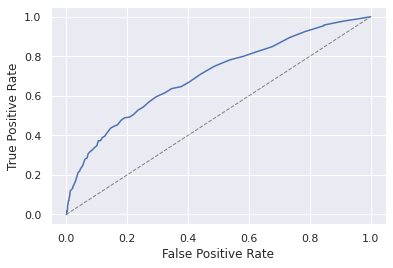

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Expondo o modelo

In [20]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

### Executando testes do modelo

In [21]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.88

(0.0, 1.0)

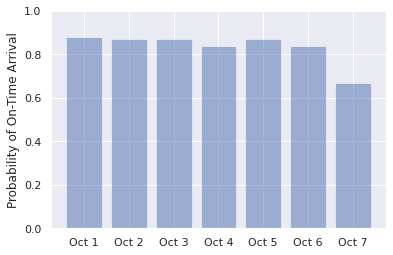

In [23]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))